In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np


In [48]:
import pandas as pd

# Load the CSV file
file_path = './mental-state.csv'
df = pd.read_csv(file_path)

# Get the number of columns
num_columns = df.shape[1]
num_columns

989

In [49]:
# Load the data
df = pd.read_csv(file_path)

# Separate input features and output label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [50]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [51]:
# Define the Transformer-based model
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, 512)
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)  # (batch_size, input_dim) -> (batch_size, 512)
        x = x.unsqueeze(1)  # (batch_size, 512) -> (batch_size, 1, 512)
        x = x.permute(1, 0, 2)  # (batch_size, 1, 512) -> (1, batch_size, 512)
        x = self.transformer_encoder(x)
        x = x.squeeze(0)  # (1, batch_size, 512) -> (batch_size, 512)
        x = self.fc(x)  # (batch_size, 512) -> (batch_size, num_classes)
        return x


In [52]:
# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
model = TransformerClassifier(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/home/rose/anaconda3/envs/muse/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [53]:
# Training the model
num_epochs = 500
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")



Epoch [1/500], Loss: 0.5322
Epoch [2/500], Loss: 0.2285
Epoch [3/500], Loss: 0.2162
Epoch [4/500], Loss: 0.1832
Epoch [5/500], Loss: 0.1737
Epoch [6/500], Loss: 0.1362
Epoch [7/500], Loss: 0.0869
Epoch [8/500], Loss: 0.0918
Epoch [9/500], Loss: 0.1322
Epoch [10/500], Loss: 0.1128
Epoch [11/500], Loss: 0.0880
Epoch [12/500], Loss: 0.0586
Epoch [13/500], Loss: 0.0515
Epoch [14/500], Loss: 0.0463
Epoch [15/500], Loss: 0.0356
Epoch [16/500], Loss: 0.0452
Epoch [17/500], Loss: 0.0365
Epoch [18/500], Loss: 0.0481
Epoch [19/500], Loss: 0.0349
Epoch [20/500], Loss: 0.0334
Epoch [21/500], Loss: 0.0355
Epoch [22/500], Loss: 0.0500
Epoch [23/500], Loss: 0.0497
Epoch [24/500], Loss: 0.0232
Epoch [25/500], Loss: 0.0271
Epoch [26/500], Loss: 0.0147
Epoch [27/500], Loss: 0.0500
Epoch [28/500], Loss: 0.0370
Epoch [29/500], Loss: 0.0338
Epoch [30/500], Loss: 0.0362
Epoch [31/500], Loss: 0.0071
Epoch [32/500], Loss: 0.0431
Epoch [33/500], Loss: 0.0448
Epoch [34/500], Loss: 0.0208
Epoch [35/500], Loss: 0

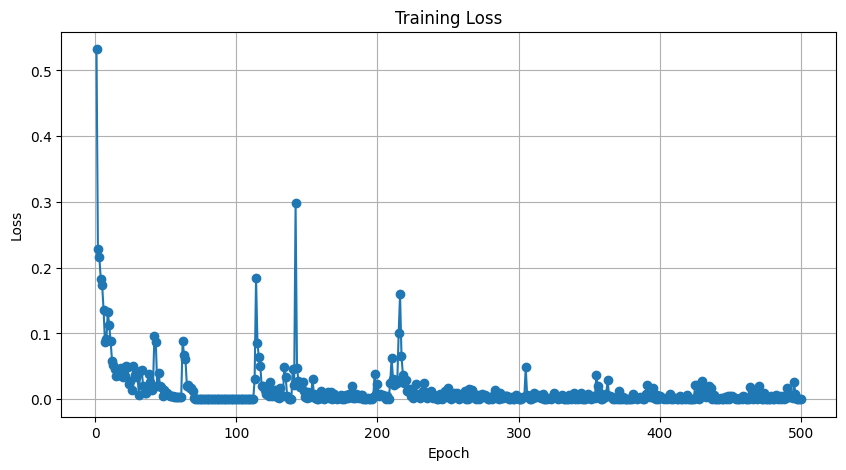

Test Accuracy: 0.9496


In [54]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


In [55]:
# Save the trained model
torch.save(model.state_dict(), 'transformer_classifier_model.pt')


In [56]:
import torch
import torch.nn as nn
import numpy as np

# Define the Transformer-based model class (same as above)
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, 512)
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)  # (batch_size, input_dim) -> (batch_size, 512)
        x = x.unsqueeze(1)  # (batch_size, 512) -> (batch_size, 1, 512)
        x = x.permute(1, 0, 2)  # (batch_size, 1, 512) -> (1, batch_size, 512)
        x = self.transformer_encoder(x)
        x = x.squeeze(0)  # (1, batch_size, 512) -> (batch_size, 512)
        x = self.fc(x)  # (batch_size, 512) -> (batch_size, num_classes)
        return x

# Load the model
input_dim = 988
num_classes = 3
model = TransformerClassifier(input_dim, num_classes)
model.load_state_dict(torch.load('transformer_classifier_model.pt'))
model.eval()

# Example inference function
def predict(input_vector):
    with torch.no_grad():
        input_tensor = torch.tensor(input_vector, dtype=torch.float32).unsqueeze(0)  # (1, input_dim)
        output = model(input_tensor)
        _, predicted_label = torch.max(output, 1)
        return predicted_label.item()

# Example usage
input_vector = np.random.rand(988)  # Example input vector of size [988]
predicted_label = predict(input_vector)
print(f"Predicted Label: {predicted_label}")


Predicted Label: 2


/home/rose/anaconda3/envs/muse/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
